# Predictive Analysis for CP Mortality Percentage of Population by Conditions Using Random Forest Regression

In [1]:
import os
from pathlib import Path
import sys

# set working directory to the module's home
cwd = os.getcwd()
os.chdir(Path(cwd).parents[0])

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from config import connect
from modeling.random_forest_regression import RFRegressor

### Connect to MySQL Database `AQI` for the Table `combined`

In [3]:
conn = connect()
cursor = conn.cursor()

In [4]:
q = "SELECT * FROM AQI.combined"
cursor.execute(q)

In [5]:
num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]
print(field_names)

['Year', 'State', 'Parameter', 'AQI', 'Age_Group', 'Population', 'CP_deaths', 'Total_deaths', 'Pct_CP_Death']


In [6]:
table_rows = cursor.fetchall()

In [7]:
df = pd.DataFrame(table_rows, columns=field_names)
df.head()

,Year,State,Parameter,AQI,Age_Group,Population,CP_deaths,Total_deaths,Pct_CP_Death
0,1980,Alabama,CO,39.61,< 1 year,63503.0,76.0,962.0,7.90
1,1980,Alabama,CO,39.61,1-4 years,237138.0,18.0,185.0,9.73
2,1980,Alabama,CO,39.61,5-9 years,314150.0,8.0,113.0,7.08
3,1980,Alabama,CO,39.61,10-14 years,328096.0,6.0,125.0,4.80
4,1980,Alabama,CO,39.61,15-19 years,377406.0,29.0,370.0,7.84


In [8]:
df.count()

Year            95569
State           95569
Parameter       95569
AQI             95569
Age_Group       94451
Population      94451
CP_deaths       94451
Total_deaths    94451
Pct_CP_Death    94451
dtype: int64

### Draw a random sample from the data of size 5000

In [9]:
sample_df = df.dropna().sample(n=5000)

### Build a Random Forest Regression (RFR) model fitted on the sample data

In [10]:
rfr = RFRegressor(target='Pct_CP_Death', features=['AQI', 'State', 'Parameter', 'Age_Group'], random_seed=123)
rfr

In [11]:
rfr.split_and_train(sample_df)

#### Hypertune model parameters and re-train it

In [12]:
parameters = {
    "n_estimators": [500, 1000, 1500, 2000],
}
rfr.hypertune(parameters)

{'n_estimators': 1000}


#### Predict the target using the train set and the test set. Plot the results for human-eye fit confirmation

In [13]:
y_predict_train, train_score = rfr.predict_score_train()
train_score

0.99979500820449

In [14]:
y_predict_test, test_score = rfr.predict_score_test()
test_score

0.9997874066998953

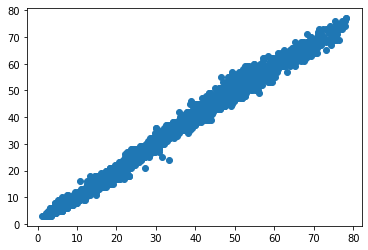

In [15]:
plt.scatter(rfr.y_train, y_predict_train)

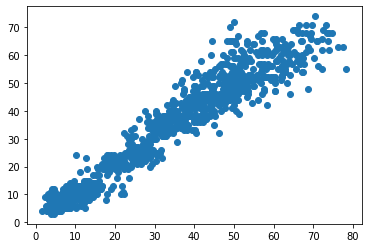

In [16]:
plt.scatter(rfr.y_test, y_predict_test)

### Run the model on a different sample set of the data to see how it performs

In [17]:
sample_df2 = df.dropna().sample(n=1000)

In [18]:
pred_df = rfr.predict_data(sample_df2)

In [19]:
# pred_df['diff'] = np.abs(pred_df.Pct_CP_Death - pred_df.predicted_Pct_CP_Death)
pred_df['less_than_5_pct_diff'] = 1
pred_df.loc[np.abs(pred_df['Pct_CP_Death'] - pred_df['predicted_Pct_CP_Death']) > 5, 'less_than_5_pct_diff'] = 0

pred_df.tail()

,Year,State,Parameter,AQI,Age_Group,Population,CP_deaths,Total_deaths,Pct_CP_Death,predicted_Pct_CP_Death,less_than_5_pct_diff
40001,1995,New Mexico,NO2,22.08,45-54 years,199108.0,226.0,865.0,26.0,26.0,1
11488,1984,Washington,Ozone,35.19,< 1 year,68927.0,46.0,703.0,7.0,5.0,1
19872,1987,Vermont,CO,32.12,45-54 years,49914.0,103.0,234.0,44.0,38.0,0
29832,1991,New York,SO2,66.58,65-74 years,1340275.0,18597.0,35036.0,53.0,53.0,1
27136,1990,New Hampshire,PM10,36.51,35-44 years,182192.0,63.0,268.0,24.0,24.0,1


In [20]:
values = pred_df.less_than_5_pct_diff.value_counts()
values[1] / (values[1] + values[0])

0.827